# Exponential Smoothing Models

This script is focused on creating exponential smoothing models to predict Ambev's cumulative revenue values, using the Statsmodels library. The goal is to train models with data up until 2020 and use these models to predict cumulative revenue values for the years 2021 and 2022. This time series will also be decomposed in terms of trend and seasonality.

The chosen evaluation metric is MAPE (Mean Absolute Percentage Error), which is commonly used to evaluate forecasts in time series. MAPE is calculated as the average of the absolute percentage differences between actual and predicted values relative to actual values.

The formula for MAPE is given by:

$MAPE = \large\frac{1}{n}\small * ∑\large|\large\frac{(Yi - Pi)}{Yi}|\small * 100$

Where:

- n is the number of observations
- $Y_i$ is the actual value of observation i
- $P_i$ is the predicted value of observation i

In addition, the script uses the Box-Pierce test (or Ljung-Box) to evaluate whether the time series has significant autocorrelation. The test checks for serial dependence in the residuals of a model fitted to the time series.

## Implementation

- Check the dataset.


- Decomposing the time series


- Creating and Training SES, Holt and Holt-Winters models.


- Making Predictions and Analyzing the outputs.

### Checking Dataset

In [17]:
# Libraries Needed
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt

sns.set()

In [18]:
# Checking the data
df_ambev = pd.read_csv(f'Data/ambev.csv', index_col=0)
df_ambev.head(5)

,Date,Acc_Revenue
0,2000-03-31,877498
1,2000-06-30,1690009
2,2000-09-30,3522524
3,2000-12-31,5250345
4,2001-03-31,1515505


In [19]:
# Transforming the Date column
df_ambev['Date'] = pd.to_datetime(df_ambev['Date'])

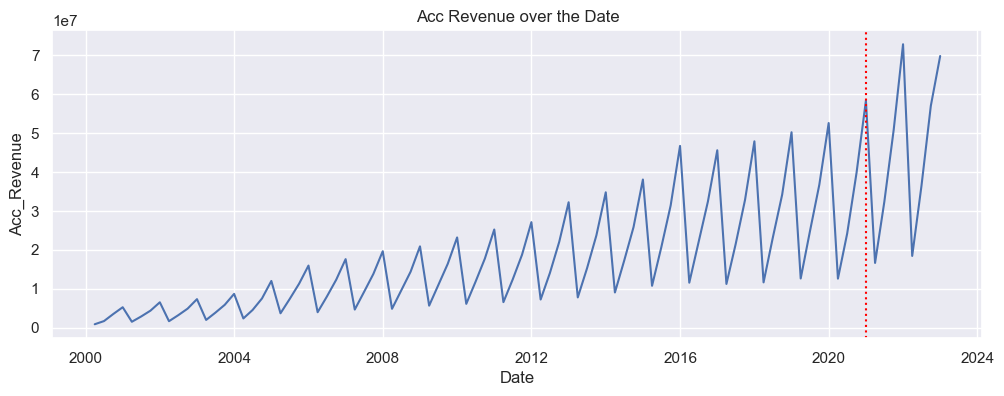

In [30]:
# Plotting the Revenue over the Date
plt.figure(figsize=(12,4))
plt.plot(df_ambev['Date'], df_ambev['Acc_Revenue'])
plt.xlabel('Date')
plt.ylabel('Acc_Revenue')
plt.title('Acc Revenue over the Date')
plt.axvline(dt.datetime(2021, 1, 1), color='red', linestyle='dotted')
plt.show();

The dotted line indicates the point at which the forecasts will begin to be made.

Now the Database will be splited on train and test.

In [57]:
# Train Dataset
df_train = df_ambev['Acc_Revenue'].loc[df_ambev['Date']<dt.datetime(2021, 1, 1)]

# Train Dataset
df_test = df_ambev['Acc_Revenue'].loc[df_ambev['Date']>=dt.datetime(2021, 1, 1)]

### Decomposing the time series

The next step will be to decompose the time series into trend and seasonality and analyze the obtained patterns.

The three exponential smoothing models (Simple, Holt, Holt-Winters) will be applied regardless of the obtained outputs, but it is known that these values impact the choice of the best model to be chosen (for example, the simple model fits better to series without trend and seasonality).

In [48]:
# Decomposing
decomposed_ts = sm.tsa.seasonal_decompose(df_ambev['Acc_Revenue'], period=4)

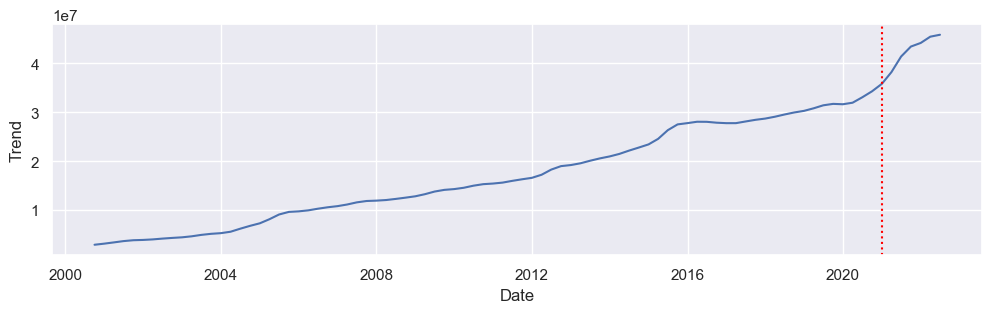

In [54]:
# Plotting the Trend
plt.figure(figsize=(12,3))
plt.plot(df_ambev['Date'], decomposed_ts.trend)
plt.xlabel('Date')
plt.ylabel('Trend')
plt.axvline(dt.datetime(2021, 1, 1), color='red', linestyle='dotted')
plt.show();

It can be observed that the time series has a clear upward trend (which even appears to increase in the last observations), which would already be an indicative that the simple model would not be the best option for this series.

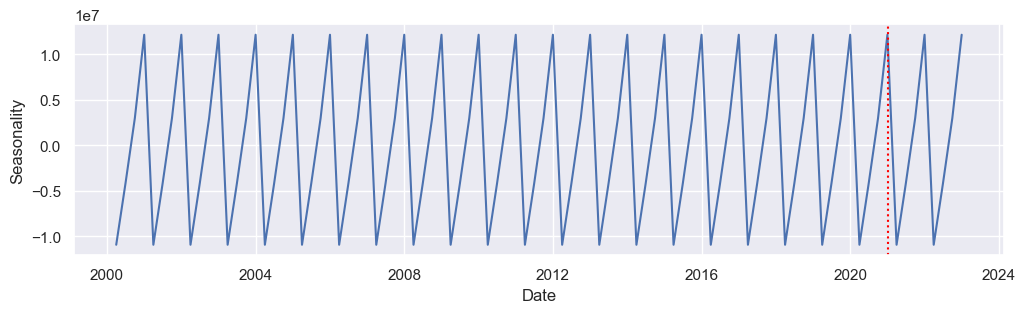

In [55]:
# Plotting the Seasonality
plt.figure(figsize=(12,3))
plt.plot(df_ambev['Date'], decomposed_ts.seasonal)
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.axvline(dt.datetime(2021, 1, 1), color='red', linestyle='dotted')
plt.show();

There is also the presence of seasonality, which would indicate that the best model would be Holt-Winters.

### Exponential Smoothing Models

Now different exponential smoothing models will be created and trained.

In [64]:
# Model SES
model_ses = sm.tsa.SimpleExpSmoothing(df_train, initialization_method='estimated')
model_ses = model_ses.fit()
model_ses.summary()

Dep. Variable:,Acc_Revenue,No. Observations:,84
Model:,SimpleExpSmoothing,SSE,8433705346940369.000
Optimized:,True,AIC,2712.176
Trend:,None,BIC,2717.038
Seasonal:,None,AICC,2712.683
Seasonal Periods:,None,Date:,"Thu, 11 May 2023"
Box-Cox:,False,Time:,17:23:10
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1486609,alpha,True
initial_level,1.9993e+06,l.0,True


In [65]:
# Model Holt Linear
model_holt = Holt(df_train, damped_trend=False, initialization_method='estimated')
model_holt = model_holt.fit()
model_holt.summary()

C:\Users\andrr\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,Acc_Revenue,No. Observations:,84
Model:,Holt,SSE,7311646662338221.000
Optimized:,True,AIC,2704.184
Trend:,Additive,BIC,2713.907
Seasonal:,None,AICC,2705.275
Seasonal Periods:,None,Date:,"Thu, 11 May 2023"
Box-Cox:,False,Time:,17:24:05
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0521429,alpha,True
smoothing_trend,0.0521429,beta,True


In [67]:
# Model Holt Winter (Additive)
model_hw_add = ExponentialSmoothing(df_train, trend='add', seasonal='add', seasonal_periods=4, initialization_method='heuristic')
model_hw_add = model_hw_add.fit()
model_hw_add.summary()

C:\Users\andrr\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,Acc_Revenue,No. Observations:,84
Model:,ExponentialSmoothing,SSE,180828731337769.062
Optimized:,True,AIC,2401.411
Trend:,Additive,BIC,2420.858
Seasonal:,Additive,AICC,2404.425
Seasonal Periods:,4,Date:,"Thu, 11 May 2023"
Box-Cox:,False,Time:,17:25:10
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1464286,alpha,True
smoothing_trend,0.1064935,beta,True


In [115]:
# Model Holt Winter (Multiplicative)
model_hw_mul = ExponentialSmoothing(df_train, trend='mul', seasonal='mul', seasonal_periods=4, initialization_method='heuristic')
model_hw_mul = model_hw_mul.fit()
model_hw_mul.summary()

C:\Users\andrr\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,Acc_Revenue,No. Observations:,84
Model:,ExponentialSmoothing,SSE,39619708390176.008
Optimized:,True,AIC,2273.881
Trend:,Multiplicative,BIC,2293.327
Seasonal:,Multiplicative,AICC,2276.894
Seasonal Periods:,4,Date:,"Thu, 11 May 2023"
Box-Cox:,False,Time:,17:49:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9242857,alpha,True
smoothing_trend,0.0684656,beta,True


AIC e BIC are model selection criteria that take into consideration the quality of the model fit to the data. The main evaluation criterion will be MAPE, but the values of AIC and BIC indicate that Holt Winter models (Additive and Multiplicative) appear to have a better fit to the data. This was already expected, since the time series presents trend and seasonality.

### Making Predictions and Evaluating the Models

Once the models have been trained, predictions for the years 2021 and 2022 will be made, plotted on a graph, and the MAPE of each model will be calculated to find the one that performs better in terms of predictive potential.

#### SES

In [116]:
# Getting SES predictions
ses_predictions = model_ses.forecast(steps=8)

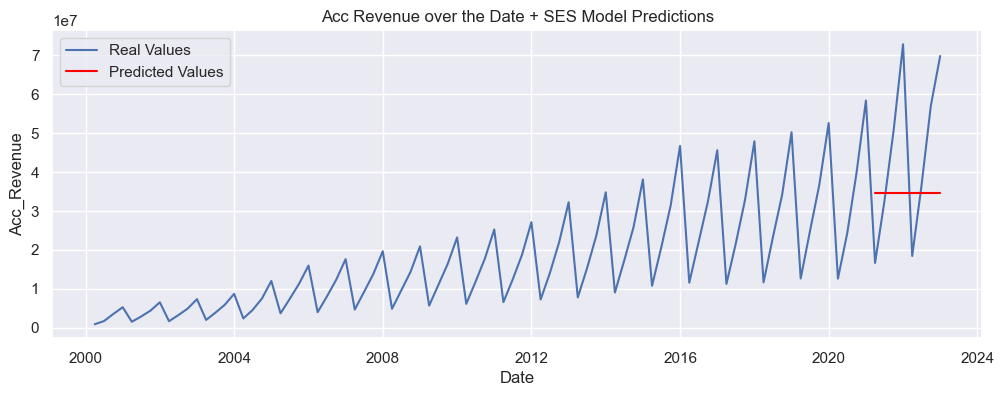

In [117]:
# Plotting SES model predictions
plt.figure(figsize=(12,4))
plt.plot(df_ambev['Date'], df_ambev['Acc_Revenue'])
plt.plot(df_ambev['Date'].loc[len(df_ambev)-8:], ses_predictions,  color='red')
plt.xlabel('Date')
plt.ylabel('Acc_Revenue')
plt.title('Acc Revenue over the Date + SES Model Predictions')
plt.legend(['Real Values', 'Predicted Values'])
plt.show();

As can be observed, the forecast of the model was not good.

In [118]:
# SES model MAPE
mape_ses = np.mean(np.abs((df_test - ses_predictions) / df_test)) * 100
print(f'MAPE: {mape_ses:.2f}%')

MAPE: 47.67%


#### HOLT

In [119]:
# Getting HOLT predictions
holt_predictions = model_holt.forecast(steps=8)

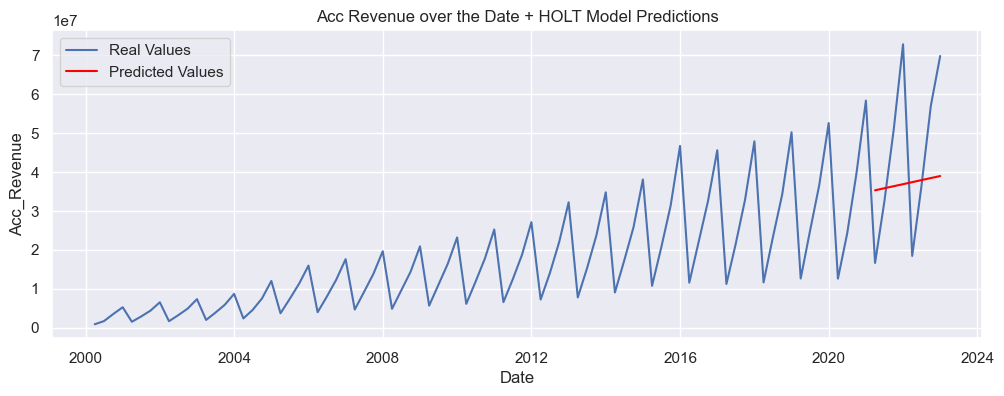

In [120]:
# Plotting HOLT model predictions
plt.figure(figsize=(12,4))
plt.plot(df_ambev['Date'], df_ambev['Acc_Revenue'])
plt.plot(df_ambev['Date'].loc[len(df_ambev)-8:], holt_predictions,  color='red')
plt.xlabel('Date')
plt.ylabel('Acc_Revenue')
plt.title('Acc Revenue over the Date + HOLT Model Predictions')
plt.legend(['Real Values', 'Predicted Values'])
plt.show();

In [121]:
# HOLT model MAPE
mape_ses = np.mean(np.abs((df_test - holt_predictions) / df_test)) * 100
print(f'MAPE: {mape_ses:.2f}%')

MAPE: 48.07%


The predictions obtained by the Holt model were also not good. The MAPE indicates that in terms of forecasting, the model is even worse than Simple Exponential Smoothing. This was already expected, since this model does not consider the seasonality present in the dataset.

#### Holt Winter Additive

In [122]:
# Getting HW Add predictions
hw_add_predictions = model_hw_add.forecast(steps=8)

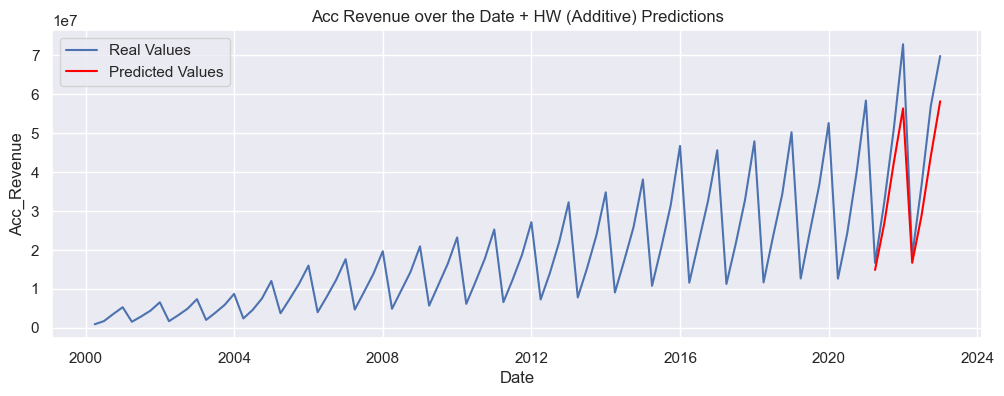

In [123]:
# Plotting HW Additive model predictions
plt.figure(figsize=(12,4))
plt.plot(df_ambev['Date'], df_ambev['Acc_Revenue'])
plt.plot(df_ambev['Date'].loc[len(df_ambev)-8:], hw_add_predictions,  color='red')
plt.xlabel('Date')
plt.ylabel('Acc_Revenue')
plt.title('Acc Revenue over the Date + HW (Additive) Predictions')
plt.legend(['Real Values', 'Predicted Values'])
plt.show();

In [124]:
# HOLT model MAPE
mape_ses = np.mean(np.abs((df_test - hw_add_predictions) / df_test)) * 100
print(f'MAPE: {mape_ses:.2f}%')

MAPE: 17.20%


Both the graph and the MAPE result indicate that the Holt Winters model is considerably better for making predictions than the models trained previously.

The graph shows a predicted value adjustment very close to the real one, but the model minimized some of the higher values.

The Holt Winters model with multiplicative trend will possibly be able to make better predictions.

#### Holt Winter Multiplicative

In [125]:
# Getting HW Multiplicative predictions
hw_mul_predictions = model_hw_mul.forecast(steps=8)

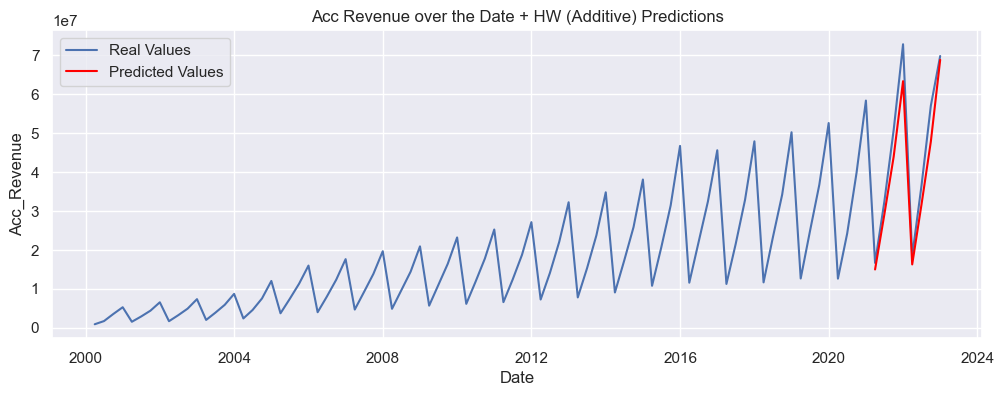

In [126]:
# Plotting HW Additive model predictions
plt.figure(figsize=(12,4))
plt.plot(df_ambev['Date'], df_ambev['Acc_Revenue'])
plt.plot(df_ambev['Date'].loc[len(df_ambev)-8:], hw_mul_predictions,  color='red')
plt.xlabel('Date')
plt.ylabel('Acc_Revenue')
plt.title('Acc Revenue over the Date + HW (Additive) Predictions')
plt.legend(['Real Values', 'Predicted Values'])
plt.show();

In [127]:
# HOLT model MAPE
mape_ses = np.mean(np.abs((df_test - hw_mul_predictions) / df_test)) * 100
print(f'MAPE: {mape_ses:.2f}%')

MAPE: 11.19%
